In [46]:
# A
# Import all necessary libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

In [48]:
# B
# Load the data
data_url = "https://raw.githubusercontent.com/amanivannan1/LA-Crime-Weather-Prediction/main/crime.csv"
df = pd.read_csv(data_url)

# Features
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
df['MONTH'] = df['DATE OCC'].dt.month
df['HOUR'] = pd.to_datetime(df['TIME OCC']).dt.hour

# Imputation with a Default Label
df['Crm Cd Desc'].fillna('UNKNOWN', inplace=True)

# Fill missing values in numerical columns with the mean
df['Vict Age'].fillna(df['Vict Age'].mean(), inplace=True)

# Fill missing values in categorical columns with a default label
df['Vict Sex'].fillna('UNKNOWN', inplace=True)

# Create 'SEASON' feature
df['SEASON'] = df['MONTH'].apply(lambda month: 'Winter' if month in [12, 1, 2] else
                                     'Spring' if month in [3, 4, 5] else
                                     'Summer' if month in [6, 7, 8] else
                                     'Fall')

In [49]:
# C
# Identify categorical columns
categorical_columns = ['SEASON']

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Define features and target variables for predicting sex
sex_features = ['SEASON_Fall', 'SEASON_Spring', 'SEASON_Summer', 'SEASON_Winter']
sex_target = 'Vict Sex'

# Define features and target variables for predicting crime type
crime_features = ['SEASON_Fall', 'SEASON_Spring', 'SEASON_Summer', 'SEASON_Winter', 'Vict Sex']
crime_target = 'Crm Cd Desc'

# Train-Test Split for sex prediction model
X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(df_encoded[sex_features], df_encoded[sex_target], test_size=0.2, random_state=42)

In [50]:
# D
# Model Selection for sex prediction model
sex_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Model Training for sex prediction model
sex_model.fit(X_sex_train, y_sex_train)

# Model Evaluation for sex prediction model
y_sex_pred = sex_model.predict(X_sex_test)

# Print Classification Report for sex prediction model
print("\nSex Prediction Model Classification Report:")
print(classification_report(y_sex_test, y_sex_pred, zero_division=1))

# Print Accuracy for sex prediction model
sex_accuracy = accuracy_score(y_sex_test, y_sex_pred)
print(f"Sex Prediction Model Accuracy is: {sex_accuracy:.2%}")


Sex Prediction Model Classification Report:
              precision    recall  f1-score   support

           F       1.00      0.00      0.00     63115
           H       1.00      0.00      0.00        15
           M       0.41      1.00      0.58     70729
     UNKNOWN       1.00      0.00      0.00     22541
           X       1.00      0.00      0.00     15132

    accuracy                           0.41    171532
   macro avg       0.88      0.20      0.12    171532
weighted avg       0.76      0.41      0.24    171532

Sex Prediction Model Accuracy is: 41.23%


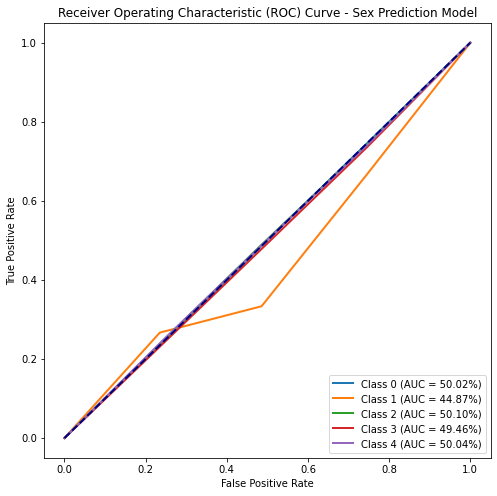

Sex Prediction Model Average AUC is: 48.90%


In [54]:
# E
# Model Evaluation for sex prediction model
y_sex_pred_proba = sex_model.predict_proba(X_sex_test)

# Binarize the labels for multi-class ROC
y_sex_test_bin = label_binarize(y_sex_test, classes=np.unique(y_sex_test))

# Initialize variables for ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(len(np.unique(y_sex_test))):
    fpr[i], tpr[i], _ = roc_curve(y_sex_test_bin[:, i], y_sex_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_sex_test_bin[:, i], y_sex_pred_proba[:, i])

# Calculate the average AUC (you can use other methods depending on your needs)
average_auc = np.mean(list(roc_auc.values()))

# Plot ROC curves for each class
plt.figure(figsize=(8, 8))
for i in range(len(np.unique(y_sex_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i] * 100:.2f}%)')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Sex Prediction Model')
plt.legend(loc='lower right')
plt.show()

# Print the AUC as a percentage
print(f"Sex Prediction Model Average AUC is: {average_auc * 100:.2f}%")

In [56]:
# F
# Identify categorical columns
categorical_columns = ['SEASON', 'Vict Sex']

# Define features and target variables for predicting crime type
crime_features = ['SEASON', 'Vict Sex']
crime_target = 'Crm Cd Desc'

# Train-Test Split for crime type prediction model
X_crime_train, X_crime_test, y_crime_train, y_crime_test = train_test_split(
    df[crime_features], df[crime_target], test_size=0.2, random_state=42
)

# Create a column transformer with one-hot encoding for categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

# Create a pipeline with preprocessing and Random Forest Classifier
crime_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Model Training for crime type prediction model
crime_model.fit(X_crime_train, y_crime_train)

# Model Evaluation for crime type prediction model
y_crime_pred = crime_model.predict(X_crime_test)

# Print Classification Report for crime type prediction model
print("\nCrime Type Prediction Model Classification Report:")
print(classification_report(y_crime_test, y_crime_pred, zero_division=1))

# Print Accuracy for crime type prediction model
crime_accuracy = accuracy_score(y_crime_test, y_crime_pred)
print(f"Crime Type Prediction Model Accuracy is: {crime_accuracy:.2%}")


Crime Type Prediction Model Classification Report:
                                                          precision    recall  f1-score   support

                                                   ARSON       1.00      0.00      0.00       479
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       1.00      0.00      0.00       217
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.11      0.20      0.14      9905
                                       ATTEMPTED ROBBERY       1.00      0.00      0.00       885
                                BATTERY - SIMPLE ASSAULT       0.10      0.50      0.16     13418
                                BATTERY ON A FIREFIGHTER       1.00      0.00      0.00        50
                                 BATTERY POLICE (SIMPLE)       1.00      0.00      0.00       470
                             BATTERY WITH SEXUAL CONTACT       1.00      0.00      0.00       729
BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM       1.

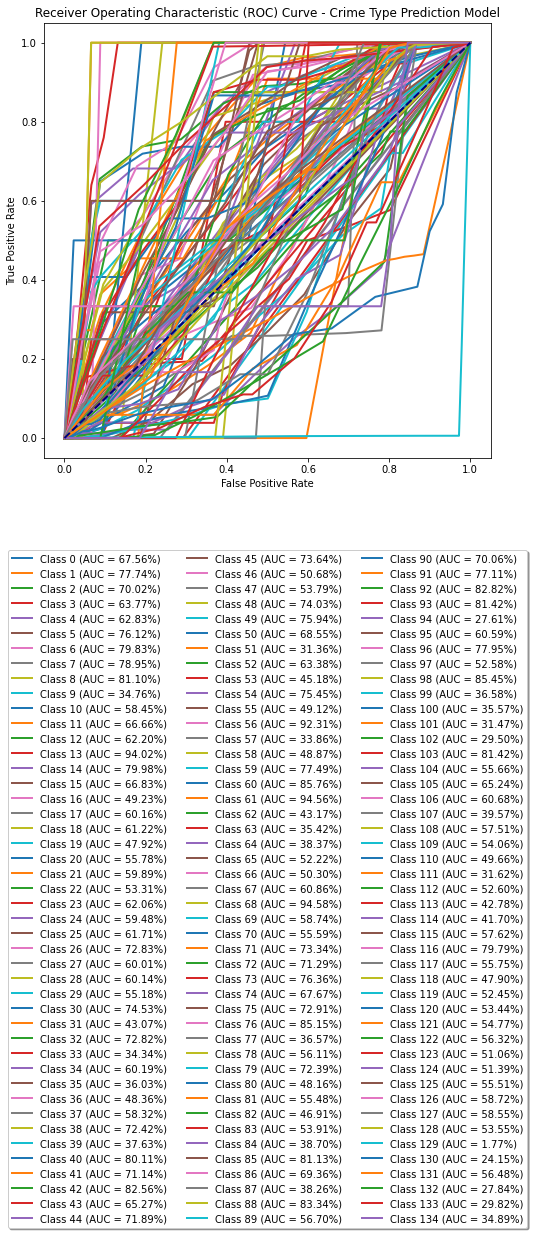

Crime Type Prediction Model Average AUC is: 58.95%


In [59]:
# G
# Model Evaluation for crime type prediction model
y_crime_pred_proba = crime_model.predict_proba(X_crime_test)

# Binarize the labels for multi-class ROC
y_crime_test_bin = label_binarize(y_crime_test, classes=np.unique(y_crime_test))

# Initialize variables for ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(len(np.unique(y_crime_test))):
    fpr[i], tpr[i], _ = roc_curve(y_crime_test_bin[:, i], y_crime_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_crime_test_bin[:, i], y_crime_pred_proba[:, i])

# Calculate the average AUC (you can use other methods depending on your needs)
average_auc = np.mean(list(roc_auc.values()))

# Plot ROC curves for each class
plt.figure(figsize=(8, 8))
for i in range(len(np.unique(y_crime_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i] * 100:.2f}%)')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Crime Type Prediction Model')

# Move below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.show()

# Print the AUC as a percentage
print(f"Crime Type Prediction Model Average AUC is: {average_auc * 100:.2f}%")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def date_to_float(x):
    d = x.split('/')
    d[2] = d[2].split(' ')[0]
    return float(d[2][2:]+'.'+d[0]+d[1])

# Import the data required
data = pd.read_csv('https://raw.githubusercontent.com/amanivannan1/LA-Crime-Weather-Prediction/main/crime.csv')
data.drop('Vict Descent', axis=1, inplace=True)
data['DATE OCC'] = data['DATE OCC'].apply(date_to_float)
df1 = pd.get_dummies(data['AREA NAME'])
data = pd.concat([data, df1], axis=1).reindex(data.index)
data.drop('AREA NAME', axis=1, inplace=True)
df2 = pd.get_dummies(data['Vict Sex'])
data = pd.concat([data, df2], axis=1).reindex(data.index)
data.drop('Vict Sex', axis=1, inplace=True)

features = data.columns.tolist()
features.remove('Crm Cd')
features.remove('Crm Cd Desc')
X = data[features]
y = data['Crm Cd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Using Random Forest Classifier
my_randomforest = RandomForestClassifier()
my_randomforest.fit(X_train, y_train)

# Feature Importance Analysis
feature_importances = pd.Series(my_randomforest.feature_importances_, index=X.columns)
top_features = feature_importances.nlargest(10)  # Adjust the number based on your preference

# Plotting the top features
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title('Top Features for Crime Prediction')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

# Print the top features
print("Top Features:")
print(top_features)